## This is code for replicating paper: "Combining Self-critical dynamics and Hebbian learning to explain utility of bursty dynamicsin neural networks" presented in the IEEE SSCI 2021 proceedings

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
# from tqdm import tqdm
from tqdm.auto import tqdm
from timeit import default_timer as timer
#import seaborn as sns
from Hopp.functions import *
from Evo.Basic_activations import *
from scipy.spatial import distance
from numba import jit

In [4]:
def probability(prob):
    prob_list=[0 for i in range(prob)]
    idx=np.random.randint(0, len(prob_list))
    prob_list[idx]=1
    return prob_list

In [6]:
#########
'''
This are functions which are nessasary to run the model. You can disable @jit extension, but that would make 
everything slower. A LOT slower.
'''
#########
prob_1=probability(4000)
@jit(nopython=True)
def prob_update_2(vec, idx, p_1):
    flag=0
#     idx=np.random.randint(low=0, high=state.shape[0])
#     add=np.sign(weights[idx,:]@state)[0]
    #if state[idx]!=np.sign(weights[idx,:]@state):
    if vec[idx]>=3:
        p=np.random.randint(low=1, high=p_1)
        if p==1:
            vec[idx]+=1
            flag=1
    else:
        vec[idx]+=1
    return vec, flag
@jit(nopython=True)
def Binary_update(state, weights, idx=0):
    idx=np.random.randint(low=0, high=state.shape[0])
    state[idx]=np.sign(weights[idx,:]@state)
    return idx
@jit(nopython=True)
def Binary_energy(state, weights):
    return -0.5*(state.T@weights@state)[0][0]
#This is update function for two-dimentional sand-pile
@jit(nopython=True)
def update(sand, crit=3):
#Single update
    total=0
    change_log=[]
    ch=1
    while ch!=0:
        change=0
        for i in range(sand.shape[0]-1):
            for j in range(sand.shape[0]-1):
                if sand[i,j]>crit:
                    sand[i,j]-=4
                    sand[i+1,j]+=1
                    sand[i-1,j]+=1
                    sand[i,j+1]+=1
                    sand[i,j-1]+=1
                    change+=4
                change_log.append(change)
        ch=change
    return change_log
def transform(vec):
    state=np.copy(vec)
    #vec[vec>=4]=1
    state[state<1]=-1
    state[state>=1]=1
    return state
@jit(nopython=True)
def update_2(sand, crit=3):
#Single update
    area=[]
    total=0
    change_log=[]
    ch=1
    while ch!=0:
        change=0
        for i in range(sand.shape[0]-1):
            for j in range(sand.shape[0]-1):
                if sand[i,j]>crit:
                    area.append((i,j))
                    sand[i,j]-=4
                    sand[i+1,j]+=1
                    area.append((i+1,j))
                    sand[i-1,j]+=1
                    area.append((i-1,j))
                    sand[i,j+1]+=1
                    area.append((i,j+1))
                    sand[i,j-1]+=1
                    area.append((i,j-1))
                    change+=4
                change_log.append(change)
        ch=change
    return change_log, set(area) 
def count_critical(sand_pile):
    critical_sites=[]
    for i in range(sand_pile.shape[0]):
        for j in range(sand_pile.shape[0]):
            sand_pile_1=np.copy(sand_pile)
            sand_pile_1[i,j]+=1
            av, area=update_2(sand_pile_1)
            if len(area)!=0:
                critical_sites.append((i,j))
    return critical_sites, len(set(critical_sites))
@jit(nopython=True)
def Binary_update(state, weights):
    idx=np.random.randint(low=0, high=state.shape[0])
    state[idx]=np.sign(weights[idx,:]@state)
@jit(nopython=True)
def update_bound(sand, boundary, crit=3):
#Single update
    area=[]
    total=0
    change_log=[]
    ch=1
    while ch!=0:
        change=0
        for i in range(sand.shape[0]):
            for j in range(sand.shape[0]):
                #bool_1=(i,j) in boundary
                if boundary.count((i,j))==0:
                    if sand[i,j]>crit:
                        area.append((i,j))
                        sand[i,j]-=4
                        sand[i+1,j]+=1
                        area.append((i+1,j))
                        sand[i-1,j]+=1
                        area.append((i-1,j))
                        sand[i,j+1]+=1
                        area.append((i,j+1))
                        sand[i,j-1]+=1
                        area.append((i,j-1))
                        change+=4
                else:
                    sand[i,j]=0
                change_log.append(change)
        ch=change
    return change_log, set(area)  
def pad(arr):
    row=np.zeros(arr.shape[0])
    arr = np.insert(arr,arr.shape[0],[row],axis= 0)
    arr = np.insert(arr,0,[row],axis= 0)
    row_2=np.zeros(arr.shape[1]+2)
    arr = np.insert(arr,0,[row_2],axis= 1)
    arr = np.insert(arr,arr.shape[1],[row_2],axis= 1)
    new_arr=np.copy(arr)
    return new_arr
# @jit(nopython=True)
def update_bound_2(sand_2, crit=3):
#Single update
    area=[]
    total=0
    change_log=[]
    ch=1
    sand=np.copy(sand_2)
    row=np.zeros(sand.shape[0])
    sand = np.insert(sand, sand.shape[0],[row],axis= 0)
    sand = np.insert(sand,0,[row],axis= 0)
    row_2=np.zeros(sand.shape[1]+2)
    sand = np.insert(sand,0,[row_2],axis= 1)
    sand = np.insert(sand,sand.shape[1],[row_2],axis= 1)
    while ch!=0:
        change=0
        for i in range(sand.shape[0]):
            for j in range(sand.shape[0]):
                #bool_1=(i,j) in boundary
                if (i==0):
                    sand[i,j]=0
                elif (i == sand.shape[0]-1):
                    sand[i,j]=0
                elif (j == 0):
                     sand[i,j]=0
                elif (j == sand.shape[0]-1):
                    sand[i,j]=0
                #if bool_1!=True:
                else:
                    if sand[i,j]>crit:
                        area.append((i,j))
                        sand[i,j]-=4
                        sand[i+1,j]+=1
                        area.append((i+1,j))
                        sand[i-1,j]+=1
                        area.append((i-1,j))
                        sand[i,j+1]+=1
                        area.append((i,j+1))
                        sand[i,j-1]+=1
                        area.append((i,j-1))
                        change+=4
                change_log.append(change)
        ch=change
    sand_3=np.copy(sand)     
    sand_3=sand_3[1:-1, 1:-1]
    #sand_2=sand[1:-1, 1:-1]
    area_2=[(a[0]-2, a[1]-2) for a in area]
    return change_log, set(area_2), sand_3

In [7]:
@jit(nopython=True)
def Self_modeling_2(state, alpha, weights):
    new_weights=state@state.T
    #new_weights=new_weights/(new_weights.shape[0]**2)
    new_weights=new_weights*alpha
    np.fill_diagonal(new_weights, 0)
    weights+=new_weights
    #return new_weights

In [8]:
@jit(nopython=True)
def Avalanche_reset(b_sand,area):
    ls_1=[-1,1]
    for a in list(area):
        idx_0, idx_1=a[0], a[1]
        b_sand[idx_0, idx_1]=ls_1[np.random.randint(2)]

In [9]:
def Binary_update_2(state, weights):
    idx=np.random.randint(low=0, high=state.shape[0])
    state[idx]=np.sign(weights[idx,:]@state)
    return idx
def getBoundary(a, m, n):
    boundary=[]
    for i in range(m):
        for j in range(n):
            if (i == 0):
                boundary.append((i,j))
            elif (i == m-1):
                boundary.append((i,j))
            elif (j == 0):
                boundary.append((i,j))
            elif (j == n-1):
                boundary.append((i,j))
    return boundary

In [10]:
#Here we generate intial state
sand_pile=np.full((20,20),4, dtype=float)
sand_shape=sand_pile.shape
vec_1=sand_pile.flatten()
state_1=transform(np.copy(vec_1))
state_1=state_1.reshape(400,1)
sand_pile=np.pad(sand_pile, pad_width=1, mode="constant", constant_values=0)
Boundary=getBoundary(sand_pile, sand_pile.shape[0], sand_pile.shape[1])
_,_=update_bound(sand_pile, Boundary)
sand_pile=sand_pile[1:-1, 1:-1]

/apps/free81/python/3.7.3/lib/python3.7/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'boundary' of function 'update_bound'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-6-e4f2e74857a4>", line 116:
@jit(nopython=True)
def update_bound(sand, boundary, crit=3):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/apps/free81/python/3.7.3/lib/python3.7/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'lst' of function 'list_count.<locals>.list_count_impl'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set

In [11]:
################
'''
This is the main loop of the model
'''
################

end_point_list=[]
area_list=[]
energy=[]
end_cor=[]
average=[]
N=400
weights=np.heaviside(np.random.choice(2, N*N),-1, dtype=float)
weights=weights.reshape(N, N)
weights=(weights+weights.T)/2
np.fill_diagonal(weights, 0)
weights_original=np.copy(weights)
J=0
count=0
with tqdm(total=400, leave=True) as pbar:
    while J<401:
        count+=1
        idx=Binary_update_2(state_1, weights)
        vec_1,flag=prob_update_2(vec_1, idx, 10000)
        energy.append(Binary_energy(state_1, weights_original))
        if flag==1:
            end_point=Binary_energy(state_1, weights_original)
            if J>200:
                Self_modeling_2(state_1, 0.0025, weights)
            new_sand=vec_1.reshape(sand_shape)
            av, area, new_sand=update_bound_2(new_sand)
            binary_sand=state_1.reshape(sand_shape)
            average.append(np.average(new_sand))
            if len(list(area))!=0:
                end_cor.append(count)
                count=0
                Avalanche_reset(binary_sand, area)
                vec_1=new_sand.flatten().reshape(400,1)
                state_1=binary_sand.flatten().reshape(400,1)
                end_point_list.append(end_point)
                area_list.append(area)
                J+=1
                pbar.update(1)

/apps/free81/python/3.7.3/lib/python3.7/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected set' found for argument 'area' of function 'Avalanche_reset'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-8-9c8fe772219f>", line 2:
@jit(nopython=True)
def Avalanche_reset(b_sand,area):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/apps/free81/python/3.7.3/lib/python3.7/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected set' found for argument 'iterable' of function 'list_constructor.<locals>.list_impl'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types



In [12]:
################################
'''
This part is for testing the model with random vectors
'''
################################
test_list=[]
for i in tqdm(range(100)):
    vec=Generate_state(400)
    for j in range(4500):
        Binary_update(vec, weights)
    test_list.append(Binary_energy(vec, weights_original))

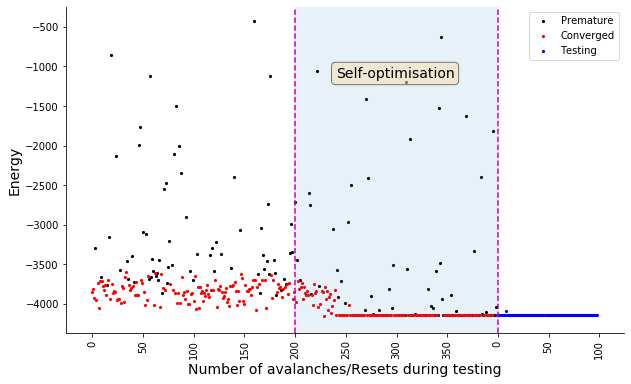

In [13]:
################################
'''
This code generates Figure 4 in the paper
'''
################################
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
x=[]
y=[]
x_1=[]
y_1=[]
types=["Converged", "Preamature"]
labels_1=[]
for i in range(0, len(end_cor)):
    if end_cor[i]<4000:
        x.append(i)
        y.append(end_point_list[i])
    else:
        x_1.append(i)
        y_1.append(end_point_list[i])
plt.figure(figsize=(10,6))
x_2=np.arange(x_1[-1], x_1[-1]+len(test_list))
plt.scatter(x, y, c = "k", s = 10,
                linewidth = 0, label="Premature")
plt.scatter(x_1, y_1, c = "r", s = 10,
                linewidth = 0, label="Converged")
plt.scatter(x_2, test_list, c = "b", s = 10,
                linewidth = 0, label="Testing")
plt.ylabel("Energy", fontsize=14)
plt.xlabel("Number of avalanches/Resets during testing", fontsize=14)
plt.axvline(200, c="m", linestyle="dashed");
plt.axvline(400, c="m", linestyle="dashed");
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
ax=plt.gca()
x_lab=[0, 50, 100, 150, 200, 250, 300, 350, 0, 50, 100]
x_ticks=[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
ax.set_xticks(x_ticks)
plt.axvspan(200, 400, alpha=0.1)
plt.text(240, -1000, "Self-optimisation", fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xticklabels(x_lab, rotation='vertical')
plt.legend()
#Uncomment this line to save the figure
#plt.savefig("good_figure_2.png")